# Logistic Regression Assignment For Amazon Reviews

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:

# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)
print(display.shape)
display.head(2)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum() # Total sum

393063

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head() # Data cleaning :duplication

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
# Droping Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [12]:
#Checking to see that how much % of data still remains in final data
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

In [16]:
######### Preprocessing Reviews Text 
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_1)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_1).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
import warnings
warnings.filterwarnings("ignore")
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:13<00:00, 2186.88it/s]


In [25]:
final['CleanedText']=preprocessed_reviews
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...


In [26]:
data=final.sample(100000)
print("For 100000 samples :\n" , data['Score'].value_counts())

For 100000 samples :
 1    84049
0    15951
Name: Score, dtype: int64


In [27]:
#Sorting According to Time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time",axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...


In [0]:
# this is for 100k points
X=data['CleanedText']
y=data['Score']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # random splitting
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix 
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform
from sklearn import linear_model, datasets
from collections import Counter
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [32]:
print("**"*60)

************************************************************************************************************************


# BOW

In [0]:
bow =CountVectorizer()

In [0]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow.fit_transform(X_train)
X_cv_bow = bow.transform(X_cv)
X_test_bow = bow.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(44890, 40603) (44890,)
(22110, 40603) (22110,)
(33000, 40603) (33000,)


### Applying Logistic Regression with L1 regularization on BOW

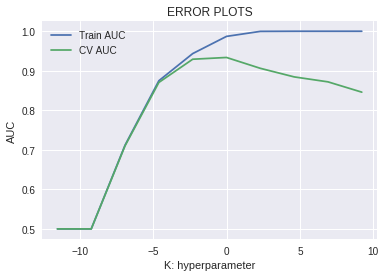

In [0]:

C = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] #declared both l1 and l2, but checking only for L1
from pylab import scatter
import pylab
import math
penalty=['l1','l2']
train_auc_l1 = []
cv_auc_l1 = []
for i in C:
    neigh_l1 = LogisticRegression(penalty='l1',C=i)
    model_l1 = neigh_l1.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred_l1 =  model_l1.predict_proba(X_train_bow)[:,1]
    y_cv_pred_l1 =  model_l1.predict_proba(X_cv_bow)[:,1]
    train_auc_l1.append(roc_auc_score(y_train,y_train_pred_l1))
    cv_auc_l1.append(roc_auc_score(y_cv, y_cv_pred_l1))
    

plt.plot(np.log(C), train_auc_l1, label='Train AUC')
plt.plot(np.log(C), cv_auc_l1, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_train = C[train_auc_l1.index(max(train_auc_l1))]
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_train)
print('-'*50)
optimal_alpha_cv = C[cv_auc_l1.index(max(cv_auc_l1))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_cv)


The optimal number of train value in C is 1000.000000.
--------------------------------------------------

The optimal number of cv value in C is 1.000000.


In [0]:
#                      ***Note :-  By using math.log we can visulize a model in correct manner.
#** By Observing to the model and max(cv) that shown the two lines are are coming and joining together at point 0.1

### Sparcity for L1 regularization
#### For More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)

In [0]:

neighl1 = LogisticRegression(penalty='l1',C=0.00001)
modell1 = neighl1.fit(X_train_bow, y_train)
w = modell1.coef_
print(np.count_nonzero(w))

0


In [0]:
neighl1 = LogisticRegression(penalty='l1',C=0.001)
modell1 = neighl1.fit(X_train_bow, y_train)
w = modell1.coef_
print(np.count_nonzero(w))

4


In [0]:
neighl1 = LogisticRegression(penalty='l1',C=0.01)
modell1 = neighl1.fit(X_train_bow, y_train)
w = modell1.coef_
print(np.count_nonzero(w))

86


In [0]:
neighl1 = LogisticRegression(penalty='l1',C=0.1)
modell1 = neighl1.fit(X_train_bow, y_train)
w = modell1.coef_
print(np.count_nonzero(w))

726


In [0]:
neighl1 = LogisticRegression(penalty='l1',C=1.0)
modell1 = neighl1.fit(X_train_bow, y_train)
w = modell1.coef_
print(np.count_nonzero(w))

3794


In [0]:
neighl1 = LogisticRegression(penalty='l1',C=100)
modell1 = neighl1.fit(X_train_bow, y_train)
w = modell1.coef_
print(np.count_nonzero(w))

8334


In [0]:
neighl1 = LogisticRegression(penalty='l1',C=1000)
modell1 = neighl1.fit(X_train_bow, y_train)
w = modell1.coef_
print(np.count_nonzero(w))

10445


In [0]:
# instantiate learning model alpha = optimal_alpha
nb_optimal = LogisticRegression(penalty='l1',C = optimal_alpha_cv)
# fitting the model
nb_optimal.fit(X_train_bow, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_bow=nb_optimal.predict(X_test_bow)
pred_bow_train=nb_optimal.predict(X_train_bow)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_bow = roc_auc_score(y_test, pred_bow)
print('\nThe auc socre for value= %f is %f%%' % (optimal_alpha_cv, auc_bow))


The auc socre for value= 1.000000 is 0.811633%


[[ 3416  1757]
 [ 1032 26795]]
   


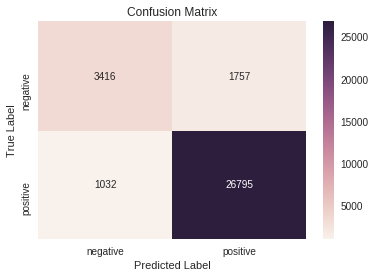

***************************************************************************
[[ 5887  1314]
 [  416 37273]]
   


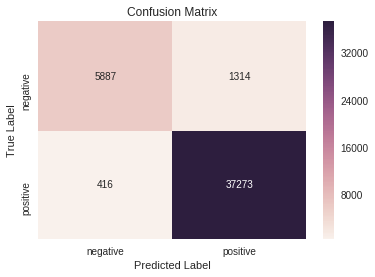

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, pred_bow)
print(cm_bow)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('***************************************************************************')

cm_bow1 = confusion_matrix(y_train, pred_bow_train)
print(cm_bow1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label1 = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm_bow1, index = class_label1, columns = class_label1)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

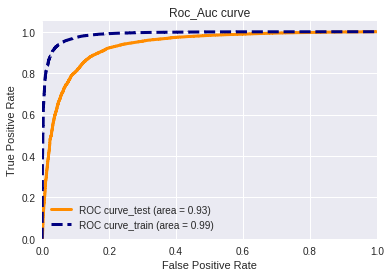

In [0]:
### Compute ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_predict =  nb_optimal.predict_proba(X_test_bow)[:,1]
y_train_predict =  nb_optimal.predict_proba(X_train_bow)[:,1]
fpr1,tpr1,_ =  metrics.roc_curve(y_train,y_train_predict) 
fpr,tpr, _ = metrics.roc_curve(y_test,y_test_predict)

roc_auc = auc(fpr, tpr) 
roc_auc1 = auc(fpr1,tpr1) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot(fpr1,tpr1, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

### Applying Logistic Regression with L2 regularization on BOW

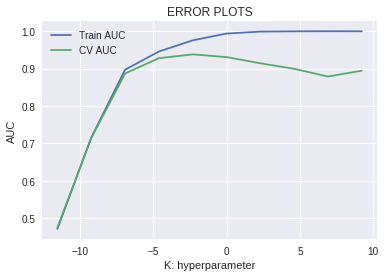

In [0]:

from pylab import scatter
import pylab
import math
train_auc_l2 = []
cv_auc_l2 = []
C= [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] ## before i have taken with same parameters 
for j in C:
    neigh_l2 = LogisticRegression(penalty='l2',C=j)
    model_l2 = neigh_l2.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred_l2 =  model_l2.predict_proba(X_train_bow)[:,1]
    y_cv_pred_l2 =  model_l2.predict_proba(X_cv_bow)[:,1]
    
    
    train_auc_l2.append(roc_auc_score(y_train,y_train_pred_l2))
    cv_auc_l2.append(roc_auc_score(y_cv, y_cv_pred_l2))
    

plt.plot(list(map(lambda x:math.log(x),C)), train_auc_l2, label='Train AUC')
plt.plot(list(map(lambda y:math.log(y),C)), cv_auc_l2, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_train1 = C[train_auc_l2.index(max(train_auc_l2))]
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_train1)
print('-'*50)
optimal_alpha_cv1 = C[cv_auc_l2.index(max(cv_auc_l2))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_cv1)


The optimal number of train value in C is 1000.000000.
--------------------------------------------------

The optimal number of cv value in C is 0.100000.


In [0]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_l2 = LogisticRegression(penalty='l2', C = optimal_alpha_cv1)
# fitting the model
nb_optimal_l2.fit(X_train_bow, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Observation : By Observing to L1 and L2 in the model i applied., max of cv is 0.1 in L2 and 1.0 in L1., max train 10000 in L1 and max train is 1000 in L2

In [0]:
#predicting
pred_bow_test1=nb_optimal_l2.predict(X_test_bow)
pred_bow_train1=nb_optimal_l2.predict(X_train_bow)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_bow1 = roc_auc_score(y_test, pred_bow_test1)
print('\nThe auc socre for value= %f is %f%%' % (optimal_alpha_cv1, auc_bow1))


The auc socre for value= 0.100000 is 0.790487%


[[ 3166  2037]
 [  765 27032]]
   


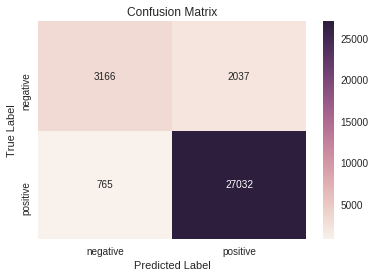

***************************************************************************
[[ 5050  2134]
 [  471 37235]]
   


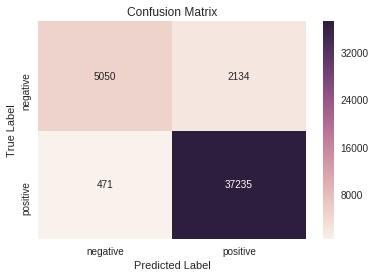

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_bow1 = confusion_matrix(y_test, pred_bow_test1)
print(cm_bow1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm_bow1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('***************************************************************************')

cm_bow2 = confusion_matrix(y_train, pred_bow_train1)
print(cm_bow2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label1 = ["negative", "positive"]
df_cm2 = pd.DataFrame(cm_bow2, index = class_label1, columns = class_label1)
sns.heatmap(df_cm2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

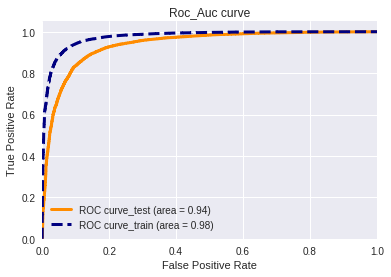

In [0]:
### Compute ROC curve and ROC area for predictions on l2 validation set
from sklearn import metrics
y_test_predict1 =  nb_optimal_l2.predict_proba(X_test_bow)[:,1]
y_train_predict1=  nb_optimal_l2.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,_ =  metrics.roc_curve(y_train,y_train_predict1) 
fpr11,tpr11, _ = metrics.roc_curve(y_test,y_test_predict1)

roc_auc_test = auc(fpr11, tpr11) 
roc_auc_train1 = auc(fpr2,tpr2) 
### Plot
plt.figure()
lw = 3 
plt.plot(fpr11, tpr11, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc_test)
plt.plot(fpr2,tpr2 , color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc_train1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

#### Performing pertubation test (multicollinearity check) on BOW,

In [0]:
neighl2 = LogisticRegression(penalty='l2',C=0.1)
modell2 = neighl2.fit(X_train_bow, y_train)
w_before_epsilon=modell2.coef_
epsilon=np.random.normal(loc=0,scale=0.1)
print(epsilon)
type(X_train_bow)
X_train_bow.shape

0.08358527744488797


(44890, 40603)

In [0]:
#finding non-zero elements positon
no_of_nonzeros=X_train_bow.nonzero()
no_of_nonzeros

(array([    0,     0,     0, ..., 44889, 44889, 44889], dtype=int32),
 array([  401,  1593,  2407, ..., 39189, 39874, 40029], dtype=int32))

In [0]:
# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix
X1=csr_matrix(X_train_bow) #getting a new data set

In [0]:
X1.data=X1.data+epsilon

Now, We are applying our new data X1 on Logestic Regression.

In [0]:
modellr=LogisticRegression(penalty='l2',C=0.1)
modellr=modellr.fit(X1,y_train)
print(np.count_nonzero(modellr.coef_))
print(modellr.score(X_test_bow,y_test))

40603
0.9143030303030303


In [0]:
w_after_epsilon=modellr.coef_

In [0]:
weights1=np.transpose(w_before_epsilon)
weights2=np.transpose(w_after_epsilon)
print(weights1.shape)
print(weights2.shape)
weights1+=10**-6
weights2+=10**-6

(40603, 1)
(40603, 1)


In [0]:
percentage_change_vector = ((weights1-weights2)/np.abs(weights1))*100
percentage_change_vector

array([[-2.5328044 ],
       [-6.57056363],
       [ 2.60498891],
       ...,
       [ 6.44499754],
       [ 3.15264931],
       [ 4.72558657]])

In [0]:
per_c_v=sorted(percentage_change_vector)

In [0]:
print(per_c_v[0])
print(per_c_v[10])
print(per_c_v[20])
print(per_c_v[30])
print(per_c_v[40])
print(per_c_v[50])
print(per_c_v[60])
print(per_c_v[70])
print(per_c_v[80])
print(per_c_v[90])
print(per_c_v[100])

[-6661.20355479]
[-1195.04599895]
[-906.66587668]
[-707.0305545]
[-707.0305545]
[-582.96800025]
[-490.79922893]
[-379.39760361]
[-338.21486531]
[-293.68022599]
[-289.35039048]


In [0]:
print("0th percentile of arr : ",np.percentile(per_c_v, 0))
print("10th percentile of arr : ",np.percentile(per_c_v, 10))
print("20th percentile of arr : ",np.percentile(per_c_v, 20))
print("30th percentile of arr : ",np.percentile(per_c_v, 30))
print("40th percentile of arr : ",np.percentile(per_c_v, 40))
print("50th percentile of arr : ",np.percentile(per_c_v, 50))
print("60th percentile of arr : ",np.percentile(per_c_v, 60))
print("70th percentile of arr : ",np.percentile(per_c_v, 70))
print("80th percentile of arr : ",np.percentile(per_c_v, 80))
print("90th percentile of arr : ",np.percentile(per_c_v, 90))
print("99th percentile of arr : ",np.percentile(per_c_v, 99))
print("100th percentile of arr : ",np.percentile(per_c_v, 100))

0th percentile of arr :  -6661.203554787885
10th percentile of arr :  -9.612588133307309
20th percentile of arr :  -5.969603625694711
30th percentile of arr :  -3.8742592468556736
40th percentile of arr :  -2.0749811643230465
50th percentile of arr :  -0.1948884206983648
60th percentile of arr :  1.8383589167885366
70th percentile of arr :  3.9219680244217514
80th percentile of arr :  6.368198143490772
90th percentile of arr :  10.364093927604774
99th percentile of arr :  30.870939424933816
100th percentile of arr :  121547.4178214593


In [0]:
print("percentile of arr 99.1 : ",np.percentile(per_c_v, 99.1),', 99.2 :',np.percentile(per_c_v, 99.2),', 99.3 :',np.percentile(per_c_v, 99.3),', 99.4 :',np.percentile(per_c_v, 99.4))

percentile of arr 99.1 :  32.32334034622081 , 99.2 : 34.87245580805438 , 99.3 : 38.770962369427494 , 99.4 : 44.86858324318844


In [0]:
print('99.5 :',np.percentile(per_c_v, 99.5), ', 99.6 :',np.percentile(per_c_v, 99.6),', 99.7 :',np.percentile(per_c_v, 99.7),', 99.8 :',np.percentile(per_c_v, 99.8),',99.9 :',np.percentile(per_c_v, 99.9),', 100th percentile :',np.percentile(per_c_v, 100))

99.5 : 53.63831099175968 , 99.6 : 69.48421310716685 , 99.7 : 97.59349846899471 , 99.8 : 150.5923580336774 ,99.9 : 275.4495307476896 , 100th percentile : 121547.4178214593


In [0]:
Vec=(np.percentile(per_c_v, 0)+np.percentile(per_c_v, 10)+np.percentile(per_c_v, 20)+np.percentile(per_c_v, 30)+np.percentile(per_c_v, 40)+np.percentile(per_c_v, 50)+np.percentile(per_c_v, 60)+np.percentile(per_c_v,70)+np.percentile(per_c_v, 80)+np.percentile(per_c_v, 90)+np.percentile(per_c_v, 100))

In [0]:
Vec_99=(np.percentile(per_c_v, 99.1)+np.percentile(per_c_v, 99.2)+np.percentile(per_c_v, 99.3)+np.percentile(per_c_v, 99.4)+np.percentile(per_c_v, 99.5)+np.percentile(per_c_v, 99.6)+np.percentile(per_c_v,99.7)+np.percentile(per_c_v, 99.8)+np.percentile(per_c_v, 99.9)+np.percentile(per_c_v, 100))
Vec_99

122345.01107457548

#### we can combine arrays of w1,w2 and percentage_change_vector


In [0]:
w1=np.abs(weights1)
w2=np.abs(weights2)

In [0]:
percentage_change_vector.shape

(40603, 1)

In [0]:
orginal_weights=np.concatenate((w1,w2,percentage_change_vector),axis=1)
orginal_weights.shape    

(40603, 3)

In [0]:
orginal_weights

array([[ 2.55713417e-02,  2.62190138e-02, -2.53280440e+00],
       [ 4.29295988e-02,  4.57503154e-02, -6.57056363e+00],
       [ 1.11287899e-03,  1.08388861e-03,  2.60498891e+00],
       ...,
       [ 2.43508181e-02,  2.59202278e-02,  6.44499754e+00],
       [ 9.85564936e-03,  9.54493530e-03,  3.15264931e+00],
       [ 1.35041711e-03,  1.28660198e-03,  4.72558657e+00]])

In [0]:
bow_for_features=CountVectorizer(binary=True,max_features=40751,dtype='float').fit(X_train)
#taken max_features=40751 for satisfying shape
features=np.asarray(bow_for_features.get_feature_names())
type(features)
features.shape

(40603,)

In [0]:
feat=sorted(features)
Data_frame=pd.DataFrame(data=orginal_weights,index=feat,columns=['weights_1','weights_2','weights_3'])
Data_frame.head(10)

,weights_1,weights_2,weights_3
aa,0.025571,0.026219,-2.532804
aaa,0.042930,0.045750,-6.570564
aaaa,0.001113,0.001084,2.604989
aaaaaaaaaaaaaaa,0.000904,0.000935,-3.347933
aaaaaaarrrrrggghhh,0.046190,0.046243,0.113547
aaaahhhhhh,0.003811,0.003662,3.912765
aadp,0.000054,0.000044,18.002161
aafco,0.002540,0.001681,33.830497
aagh,0.020623,0.022113,-7.225639
aahs,0.000007,0.000005,28.368822


### According to percentile calculation printing the feature names whose % change  is more than 30

In [0]:
print(Data_frame.loc[Data_frame['weights_3'] > 30])

                weights_1  weights_2    weights_3
aafco            0.002540   0.001681    33.830497
abuse            0.005573   0.007539    35.279750
accidents        0.002726   0.000915    66.423325
adding           0.000294   0.005944  1918.342726
addressing       0.002075   0.004235   104.113499
adjust           0.003360   0.011996   257.050877
administration   0.001999   0.002706    35.392990
aforementioned   0.008485   0.015126    78.271246
aggravating      0.005007   0.007026    40.338248
album            0.000010   0.000006    32.323340
allocations      0.000010   0.000006    32.323340
allows           0.013621   0.005581    59.027028
americanized     0.001658   0.002322    40.033774
amply            0.007120   0.010721    50.572822
amused           0.005099   0.006681    31.022683
arabic           0.002644   0.001547    41.515841
areas            0.017168   0.022857    33.140903
arranging        0.000023   0.000205  1000.685575
attractively     0.009560   0.013256    38.654842


### Selecting Top 20 Features

In [0]:
features_frame=pd.DataFrame(data=weights1,index=features,columns=['w1'])
features_frame=features_frame.sort_values(by=['w1'])
features_pos=(features_frame.loc[features_frame['w1'] > 1])
features_neg=(features_frame.loc[features_frame['w1'] < -1])

In [0]:
print(features_pos[0:10]) # 10 positive features
print(features_neg[0:10]) # 10 negative features

                 w1
amazing    1.001779
wonderful  1.032807
awesome    1.045839
hooked     1.093434
great      1.097335
highly     1.139536
best       1.228586
loves      1.240767
delicious  1.304607
perfect    1.339252
                      w1
worst          -1.686647
disappointing  -1.499229
terrible       -1.470052
awful          -1.461287
horrible       -1.438975
disappointed   -1.320318
bland          -1.176181
rip            -1.109347
disappointment -1.080814
stale          -1.011759


***Note :-
    *** There are total 20 features, in that with positive number is can taken as positive feature values and with negative number is can taken as negative feature value

In [0]:
print("**"*60)

************************************************************************************************************************


# TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#TF-IDF
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500, ngram_range=(1,2)).fit(X_train)
X_train_tfidf = tf_idf_vect.transform(X_train)
X_train_tfidf

<44890x500 sparse matrix of type '<class 'numpy.float64'>'
	with 857858 stored elements in Compressed Sparse Row format>

***point*** :-For Bow i didn't taken any max_features while procesing, but in tfidf i have taken max_features=500., to check only 500 features., to do process fast

In [0]:
X_test_tfidf = tf_idf_vect.transform(X_test)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


### Applying Log reg Tfidf for L1 regularization

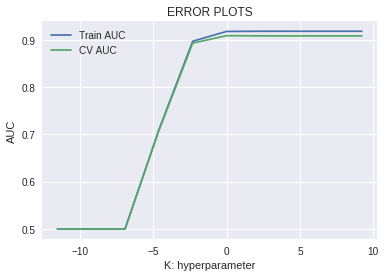

In [0]:
C = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] #declared both l1 and l2, but checking only for L1
from pylab import scatter
import pylab
import math
penalty=['l1','l2']
train_auc_tfidf_l1 = []
cv_auc_tfidf_l1 = []
for i in C:
    neigh_tfidf_l1 = LogisticRegression(penalty='l1',C=i)
    model_tfidf_l1 = neigh_tfidf_l1.fit(X_train_tfidf, y_train)
    y_train_pred_l1 =  model_tfidf_l1.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred_l1 =  model_tfidf_l1.predict_proba(X_cv_tfidf)[:,1]
    train_auc_tfidf_l1.append(roc_auc_score(y_train,y_train_pred_l1))
    cv_auc_tfidf_l1.append(roc_auc_score(y_cv, y_cv_pred_l1))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C, cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_auc_tfidf_l1, label='Train AUC')
plt.plot(np.log(C), cv_auc_tfidf_l1, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_tfidf_train = C[train_auc_tfidf_l1.index(max(train_auc_tfidf_l1))]
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_tfidf_train)
print('-'*50)
optimal_alpha_tfidf_cv = C[cv_auc_tfidf_l1.index(max(cv_auc_tfidf_l1))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_tfidf_cv)


The optimal number of train value in C is 10.000000.
--------------------------------------------------

The optimal number of cv value in C is 1.000000.


In [0]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_tfidf = LogisticRegression(penalty='l1',C = optimal_alpha_tfidf_cv)
# fitting the model
nb_optimal_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_tfidf=nb_optimal_tfidf.predict(X_test_tfidf)
pred_tfidf_train=nb_optimal_tfidf.predict(X_train_tfidf)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_tfidf = roc_auc_score(y_test, pred_tfidf)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_tfidf_cv, auc_tfidf))


The Auc socre for value= 1.000000 is 0.731133%


[[ 2615  2649]
 [  957 26779]]
   


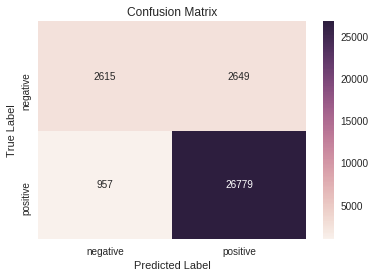

*************************************************************************************************
[[ 3647  3436]
 [ 1224 36583]]
   


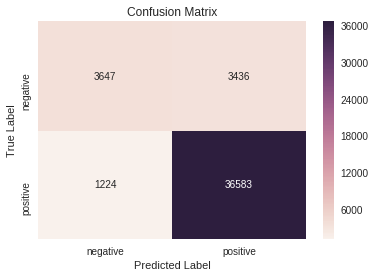

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_tfidf = confusion_matrix(y_test, pred_tfidf)
print(cm_tfidf)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_tfidf = pd.DataFrame(cm_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_tfidf1 = confusion_matrix(y_train, pred_tfidf_train)
print(cm_tfidf1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label1 = ["negative", "positive"]
df_cm1_tfidf = pd.DataFrame(cm_tfidf1, index = class_label1, columns = class_label1)
sns.heatmap(df_cm1_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

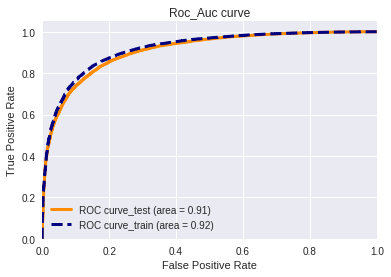

In [0]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_tfidf_predict =  nb_optimal_tfidf.predict_proba(X_test_tfidf)[:,1]
y_train_tfidf_predict =  nb_optimal_tfidf.predict_proba(X_train_tfidf)[:,1]
fpr_tfidf,tpr_tfidf,_ =  metrics.roc_curve(y_train,y_train_tfidf_predict) 
fpr_tfidf_l1,tpr_tfidf_l1, _ = metrics.roc_curve(y_test,y_test_tfidf_predict)

roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf) 
roc_auc1_tfidf = auc(fpr_tfidf_l1,tpr_tfidf_l1) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr_tfidf_l1, tpr_tfidf_l1, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc1_tfidf)
plt.plot( fpr_tfidf,tpr_tfidf, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc_tfidf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

### Applying Logistic regression on L2 

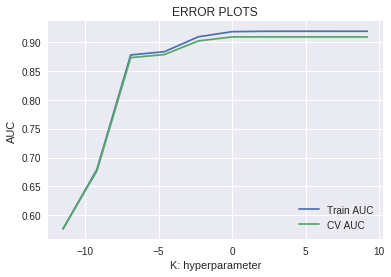

In [0]:
#C = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
#penalty=['l1','l2']  declared both l1 and l2, but checking only for L1
train_auc_tfidf_l2 = []
cv_auc_tfidf_l2 = []
for j in C: # C delared in l1
    neigh_tfidf_l2 = LogisticRegression(penalty='l2',C=j)
    model_tfidf_l2 = neigh_tfidf_l2.fit(X_train_tfidf, y_train)
    y_train_pred_l2 =  model_tfidf_l2.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred_l2 =  model_tfidf_l2.predict_proba(X_cv_tfidf)[:,1]
    train_auc_tfidf_l2.append(roc_auc_score(y_train,y_train_pred_l2))
    cv_auc_tfidf_l2.append(roc_auc_score(y_cv, y_cv_pred_l2))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_auc_tfidf_l2, label='Train AUC')
plt.plot(np.log(C), cv_auc_tfidf_l2, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_tfidf1_train = C[train_auc_tfidf_l2.index(max(train_auc_tfidf_l2))]
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_tfidf1_train)
print('-'*50)
optimal_alpha_tfidf1_cv = C[cv_auc_tfidf_l2.index(max(cv_auc_tfidf_l2))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_tfidf1_cv)


The optimal number of train value in C is 100.000000.
--------------------------------------------------

The optimal number of cv value in C is 10.000000.


In [0]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_tfidf_l2 = LogisticRegression(penalty='l2',C = optimal_alpha_tfidf1_cv)
# fitting the model
nb_optimal_tfidf_l2.fit(X_train_tfidf, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_tfidf_l2=nb_optimal_tfidf_l2.predict(X_test_tfidf)
pred_tfidf_train_l2=nb_optimal_tfidf_l2.predict(X_train_tfidf)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_tfidf_l2 = roc_auc_score(y_test, pred_tfidf_l2)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_tfidf1_cv, auc_tfidf_l2))


The Auc socre for value= 10.000000 is 0.736375%


[[ 2681  2583]
 [ 1014 26722]]
   


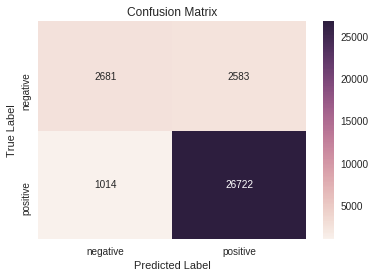

******************************************************************************************************************************
[[ 3757  3326]
 [ 1290 36517]]
   


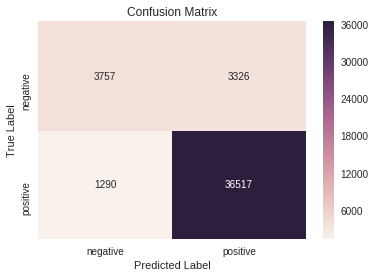

In [0]:
# Confusion Matrix
#from sklearn.metrics import confusion_matrix
cm_tfidf_l2 = confusion_matrix(y_test, pred_tfidf_l2)
print(cm_tfidf_l2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
#import seaborn as sns
#class_label = ["negative", "positive"] already declared in above l1
df_cm_tfidf_l2 = pd.DataFrame(cm_tfidf_l2, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfidf_l2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*63)
cm_tfidf1_l2 = confusion_matrix(y_train, pred_tfidf_train_l2)
print(cm_tfidf1_l2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
df_cm1_tfidf_l2 = pd.DataFrame(cm_tfidf1_l2, index = class_label, columns = class_label)
sns.heatmap(df_cm1_tfidf_l2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

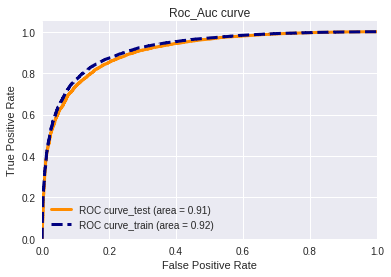

In [0]:
### Computing ROC curve and ROC area for predictions on l2 validation set
y_test_tfidf_predict_l2 =  nb_optimal_tfidf_l2.predict_proba(X_test_tfidf)[:,1]
y_train_tfidf_predict_l2 =  nb_optimal_tfidf_l2.predict_proba(X_train_tfidf)[:,1]
fpr_tfidf_l2,tpr_tfidf_l2,_ =  metrics.roc_curve(y_train,y_train_tfidf_predict_l2) 
fpr_tfidf1_l2,tpr_tfidf1_l2, _ = metrics.roc_curve(y_test,y_test_tfidf_predict_l2)

roc_auc_tfidf_l2 = auc(fpr_tfidf_l2, tpr_tfidf_l2) 
roc_auc1_tfidf_l2 = auc(fpr_tfidf1_l2,tpr_tfidf1_l2) 
### Plot
plt.figure()
#lw = 3
plt.plot(fpr_tfidf1_l2, tpr_tfidf1_l2, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc1_tfidf_l2)
plt.plot(fpr_tfidf_l2,tpr_tfidf_l2 , color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc_tfidf_l2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()
# train auc 0.92 ani chepav, kani stright line vachindhi enti?
#this is log reg assignment sir

### Selecting Top 20 Features for TF-IDF

In [0]:
features_tfidf=np.asarray(tf_idf_vect.get_feature_names())
type(features_tfidf)
features_tfidf.shape

(500,)

In [0]:
w=nb_optimal_tfidf.coef_
weights=np.transpose(w)
features_frame_tfidf=pd.DataFrame(data=weights,index=features_tfidf,columns=['weights'])
features_frame_tfidf=features_frame_tfidf.sort_values(by=['weights'])
features_tfidf_pos=(features_frame_tfidf.loc[features_frame_tfidf['weights'] > 1]) # Pos Features <1
features_tfidf_neg=(features_frame_tfidf.loc[features_frame_tfidf['weights'] < 0]) # Neg Features
print(features_tfidf_pos[0:10])
print(features_tfidf_neg[0:10])

          weights
treat    1.001916
full     1.002813
try      1.008532
close    1.011068
time     1.012370
cheaper  1.021102
regular  1.029043
say      1.034311
keurig   1.043326
stars    1.063235
               weights
disappointed -5.637564
not          -5.415988
money        -4.834120
away         -3.958035
thought      -3.557958
maybe        -3.376473
not even     -3.276807
bad          -3.209312
would not    -2.755708
tasted       -2.700303


In [0]:
print("**"*60)

************************************************************************************************************************


# W2V

In [0]:
#W2V

import re
import string
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned 
# Removing the Punctuations and HTML Tags too

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [34]:
import gensim
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())
w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count=5,size=200, workers=4)    
type(w2v_model)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13017
sample words  ['one', 'cats', 'developed', 'food', 'allergy', 'throwing', 'anything', 'ate', 'many', 'types', 'vet', 'recommended', 'trying', 'duck', 'venison', 'etc', 'refused', 'eat', 'found', 'good', 'thank', 'goodness', 'something', 'not', 'aggravate', 'allergies', 'served', 'miracle', 'noodle', 'rice', 'orange', 'ginger', 'chicken', 'tonight', 'dinner', 'texture', 'bit', 'odd', 'think', 'let', 'drain', 'dry', 'really', 'fill', 'meal', 'filling', 'no', 'calories', 'ever', 'beat']


In [0]:
# List of sentence in X_test text
sent_of_test=[]
for sent1 in X_test:
    sent_of_test.append(sent1.split())   
#List of sentences in X_cv
sent_of_cv=[]
for sent2 in X_cv:
    sent_of_cv.append(sent2.split())

# AVG W2V

In [0]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent1 in list_of_sentance:
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word1 in sent1: # 
        if word1 in w2v_words:
            vec = w2v_model.wv[word1]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent11 in sent_of_test:
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word11 in sent11: # 
        if word11 in w2v_words:
            vec = w2v_model.wv[word11]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 
    
# compute average word2vec for each review for X_cv .
cv_vectors = []; 
for sent111 in sent_of_cv:
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word111 in sent111: # 
        if word111 in w2v_words:
            vec = w2v_model.wv[word111]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_vectors.append(sent_vec) 

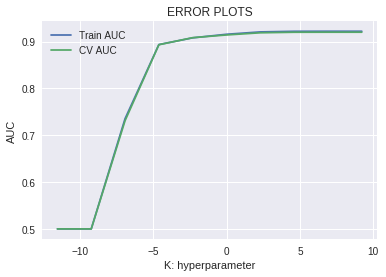

In [36]:
C = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
penalty=['l1','l2'] 
train_avg_l1 = []
cv_avg_l1= []
for k in C:
    neigh_avg_l1 = LogisticRegression(penalty='l1',C=k)
    model_avg_l1 = neigh_avg_l1.fit(train_vectors, y_train)
    y_train_predavg_l1 =  model_avg_l1.predict_proba(train_vectors)[:,1]
    y_cv_predavg_l1 =  model_avg_l1.predict_proba(cv_vectors)[:,1]
    train_avg_l1.append(roc_auc_score(y_train,y_train_predavg_l1))
    cv_avg_l1.append(roc_auc_score(y_cv, y_cv_predavg_l1))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_avg_l1, label='Train AUC')
plt.plot(np.log(C), cv_avg_l1, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [37]:
optimal_alpha_w2v_train = C[train_avg_l1.index(max(train_avg_l1))] 
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_w2v_train)
print('-'*50)
optimal_alpha_w2v_cv = C[cv_avg_l1.index(max(cv_avg_l1))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_w2v_cv)


The optimal number of train value in C is 1000.000000.
--------------------------------------------------

The optimal number of cv value in C is 1000.000000.


In [38]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_w2v_l1 = LogisticRegression(penalty='l1',C = optimal_alpha_w2v_cv)
# fitting the model
nb_optimal_w2v_l1.fit(train_vectors, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
pred_w2v_l1=nb_optimal_w2v_l1.predict(test_vectors)
pred_w2v_train_l1=nb_optimal_w2v_l1.predict(train_vectors)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_w2v_l1 = roc_auc_score(y_test, pred_w2v_l1)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_w2v_cv, auc_w2v_l1))


The Auc socre for value= 1000.000000 is 0.747438%


[[ 2769  2490]
 [  878 26863]]
   


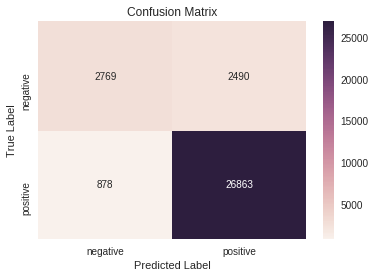

*************************************************************************************************
[[ 3780  3235]
 [ 1190 36685]]
   


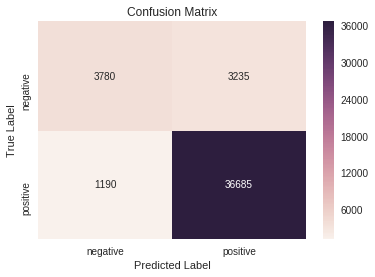

In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_avg = confusion_matrix(y_test, pred_w2v_l1)
print(cm_avg)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_w2v = pd.DataFrame(cm_avg, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_avg1 = confusion_matrix(y_train, pred_w2v_train_l1)
print(cm_avg1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label1 = ["negative", "positive"]
df_cm1_w2v = pd.DataFrame(cm_avg1, index = class_label, columns = class_label)
sns.heatmap(df_cm1_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

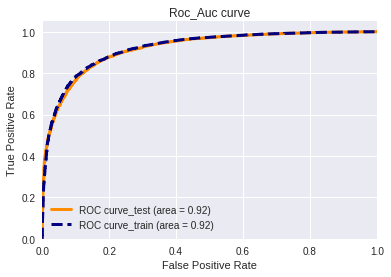

In [41]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_w2v_predict =  nb_optimal_w2v_l1.predict_proba(test_vectors)[:,1]
y_train_w2v_predict =  nb_optimal_w2v_l1.predict_proba(train_vectors)[:,1]
fpr,tpr,_ =  metrics.roc_curve(y_train,y_train_w2v_predict) 
fpr_l1,tpr_l1, _ = metrics.roc_curve(y_test,y_test_w2v_predict)

roc_auc = auc(fpr_l1, tpr_l1) 
roc_auc1 = auc(fpr,tpr) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr_l1, tpr_l1, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot( fpr,tpr, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## Appplying Log reg on AVG w2v using L2

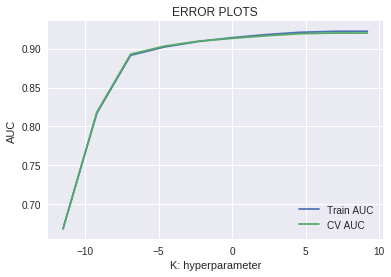

In [42]:
#C = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
#penalty=['l1','l2'] Already declared in L1
train_avg_l2 = []
cv_avg_l2= []
for a in C:
    neigh_avg_l2 = LogisticRegression(penalty='l2',C=a)
    model_avg_l2 = neigh_avg_l2.fit(train_vectors, y_train)
    y_train_predavg_l2 =  model_avg_l2.predict_proba(train_vectors)[:,1]
    y_cv_predavg_l2 =  model_avg_l2.predict_proba(cv_vectors)[:,1]
    train_avg_l2.append(roc_auc_score(y_train,y_train_predavg_l2))
    cv_avg_l2.append(roc_auc_score(y_cv, y_cv_predavg_l2))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_avg_l2, label='Train AUC')
plt.plot(np.log(C), cv_avg_l2, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [43]:
optimal_alpha_w2v1_train = C[train_avg_l2.index(max(train_avg_l2))] 
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_w2v1_train)
print('-'*50)
optimal_alpha_w2v1_cv = C[cv_avg_l2.index(max(cv_avg_l2))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_w2v1_cv)


The optimal number of train value in C is 10000.000000.
--------------------------------------------------

The optimal number of cv value in C is 1000.000000.


In [44]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_w2v_l2 = LogisticRegression(penalty='l2',C = optimal_alpha_w2v1_cv)
# fitting the model
nb_optimal_w2v_l2.fit(train_vectors, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
pred_w2v_l2=nb_optimal_w2v_l2.predict(test_vectors)
pred_w2v_train_l2=nb_optimal_w2v_l2.predict(train_vectors)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_w2v_l2 = roc_auc_score(y_test, pred_w2v_l2)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_w2v1_cv, auc_w2v_l2))


The Auc socre for value= 1000.000000 is 0.748158%


[[ 2776  2483]
 [  875 26866]]
   


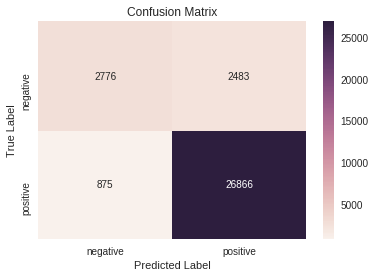

*************************************************************************************************
[[ 3782  3233]
 [ 1201 36674]]
   


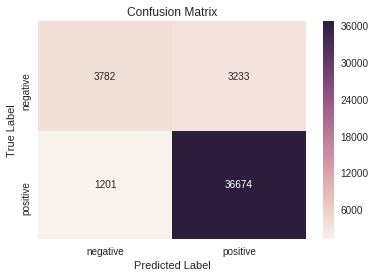

In [46]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_avg11 = confusion_matrix(y_test, pred_w2v_l2)
print(cm_avg11)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label = ["negative", "positive"]
df_cm_w2v11 = pd.DataFrame(cm_avg11, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2v11, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_avg2 = confusion_matrix(y_train, pred_w2v_train_l2)
print(cm_avg2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label1 = ["negative", "positive"]
df_cm1_w2v2 = pd.DataFrame(cm_avg2, index = class_label, columns = class_label)
sns.heatmap(df_cm1_w2v2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

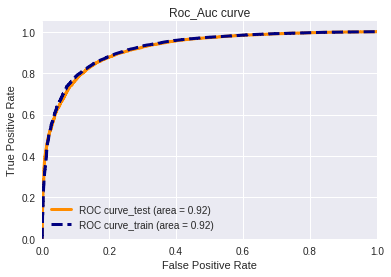

In [47]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_w2v_predict1 =  nb_optimal_w2v_l2.predict_proba(test_vectors)[:,1]
y_train_w2v_predict1 =  nb_optimal_w2v_l2.predict_proba(train_vectors)[:,1]
fpr1,tpr1,_ =  metrics.roc_curve(y_train,y_train_w2v_predict1) 
fpr_l2,tpr_l2, _ = metrics.roc_curve(y_test,y_test_w2v_predict1)

roc_auc11 = auc(fpr_l2, tpr_l2) 
roc_aucl2 = auc(fpr1,tpr1) 
### Plot
plt.figure()
#lw = 3
plt.plot(fpr_l2, tpr_l2, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc11)
plt.plot( fpr1,tpr1,color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_aucl2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## TF_IDF W2v

In [36]:
# TF-IDF weighted Word2Vec
tfidf_vectorizer = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
final_tfidf_test = tfidf_vectorizer.transform(X_test)
final_tfidf_cv = tfidf_vectorizer.transform(X_cv)
dictionary = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf_vectorizer.idf_)))

# tfidf words/col-names
tfidf_features = tfidf_vectorizer.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for senttrain in tqdm(list_of_sentance): 
    sent_vec_train = np.zeros(200) 
    weight_sum_train =0; 
    for word_train in senttrain: 
        if word_train in w2v_words and word_train in tfidf_features:
            vec_1 = w2v_model.wv[word_train]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_train = final_tfidf_train[row, tfidf_features.index(word_train)]
            tfidf_train = dictionary[word_train]*(senttrain.count(word_train)/len(senttrain))
            sent_vec_train += (vec_1 * tfidf_train)
            weight_sum_train += tfidf_train
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_train_vectors.append(sent_vec_train)
    row += 1

100%|██████████| 44890/44890 [15:14<00:00, 48.11it/s]


In [37]:
# compute TFIDF Weighted Word2Vec for each review for X_cv .
tfidf_cv_vectors = []; 
#row=0;
for sentcv in tqdm(sent_of_cv): 
    sent_vec_cv = np.zeros(200) 
    weight_sum_cv =0; 
    for word_cv in sentcv: 
        if word_cv in w2v_words and word_cv in tfidf_features:
            vec_2 = w2v_model.wv[word_cv]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_cv = final_tfidf_cv[row, tfidf_features.index(word)]
            tfidf_cv = dictionary[word_cv]*(sentcv.count(word_cv)/len(sentcv))
            sent_vec_cv += (vec_2 * tfidf_cv)
            weight_sum_cv += tfidf_cv
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_cv_vectors.append(sent_vec_cv)
    row += 1

100%|██████████| 22110/22110 [07:32<00:00, 48.90it/s]


In [38]:
# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
#row=0;
for senttest in tqdm(sent_of_test): 
    sent_vec_test = np.zeros(200) 
    weight_sum_test =0; 
    for word_test in senttest: 
        if word_test in w2v_words and word_test in tfidf_features:
            vec_3 = w2v_model.wv[word_test]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_test = final_tfidf_test[row, tfidf_features.index(word)]
            tfidf_test = dictionary[word_test]*(senttest.count(word_test)/len(senttest))
            sent_vec_test += (vec_3 * tfidf_test)
            weight_sum_test += tfidf_test
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_test_vectors.append(sent_vec_test)
    row += 1

100%|██████████| 33000/33000 [11:20<00:00, 48.46it/s]


## Log reg using L1

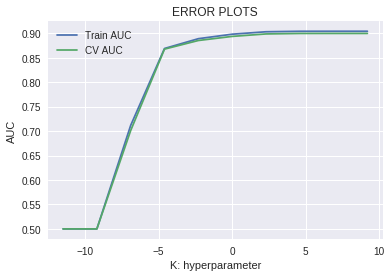

In [40]:
C = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
penalty=['l1','l2'] 
train_w2v_l1 = []
cv_w2v_l1= []
for b in C:
    neigh_w2v_l1 = LogisticRegression(penalty='l1',C=b)
    model_w2v_l1 = neigh_w2v_l1.fit(tfidf_train_vectors, y_train)
    y_train_predw2v_l1 =  model_w2v_l1.predict_proba(tfidf_train_vectors)[:,1]
    y_cv_predw2v_l1 =  model_w2v_l1.predict_proba(tfidf_cv_vectors)[:,1]
    train_w2v_l1.append(roc_auc_score(y_train,y_train_predw2v_l1))
    cv_w2v_l1.append(roc_auc_score(y_cv, y_cv_predw2v_l1))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_w2v_l1, label='Train AUC')
plt.plot(np.log(C), cv_w2v_l1, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [41]:
optimal_alpha_tfw2v_train = C[train_w2v_l1.index(max(train_w2v_l1))] 
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_tfw2v_train)
print('-'*50)
optimal_alpha_tfw2v_cv = C[cv_w2v_l1.index(max(cv_w2v_l1))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_tfw2v_cv)


The optimal number of train value in C is 10000.000000.
--------------------------------------------------

The optimal number of cv value in C is 10000.000000.


In [42]:
# instantiate learning model alpha = optimal_alpha
optimal_w2v_l1 = LogisticRegression(penalty='l1',C = optimal_alpha_tfw2v_cv)
# fitting the model
optimal_w2v_l1.fit(tfidf_train_vectors, y_train)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
pred_tfw2v_l1=optimal_w2v_l1.predict(tfidf_test_vectors)#test
pred_tfw2v_train_l1=optimal_w2v_l1.predict(tfidf_train_vectors)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_of_l1 = roc_auc_score(y_test, pred_tfw2v_l1)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_tfw2v_cv, auc_of_l1))


The Auc socre for value= 10000.000000 is 0.709738%


[[ 2372  2881]
 [  890 26857]]
   


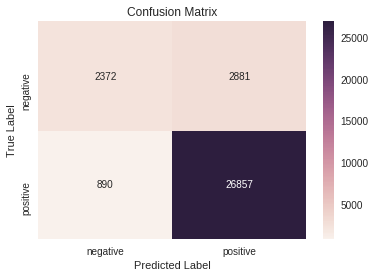

*************************************************************************************************
[[ 3299  3783]
 [ 1174 36634]]
   


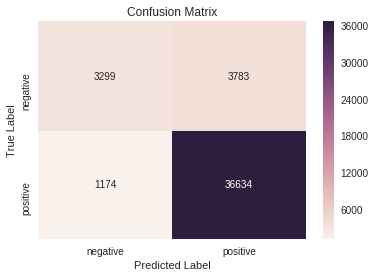

In [44]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_w2v = confusion_matrix(y_test, pred_tfw2v_l1)
print(cm_w2v)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_conf_w2v = pd.DataFrame(cm_w2v, index = class_label, columns = class_label)
sns.heatmap(df_conf_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_w2v1 = confusion_matrix(y_train, pred_tfw2v_train_l1)
print(cm_w2v1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label1 = ["negative", "positive"]
df_conf1_w2v = pd.DataFrame(cm_w2v1, index = class_label, columns = class_label)
sns.heatmap(df_conf1_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

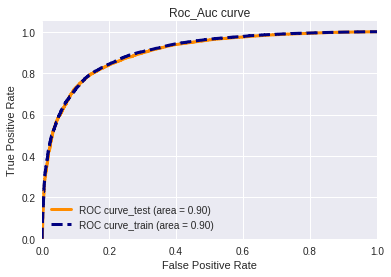

In [45]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_tfw2v_predict = optimal_w2v_l1.predict_proba(tfidf_test_vectors)[:,1]
y_train_tfw2v_predict = optimal_w2v_l1.predict_proba(tfidf_train_vectors)[:,1]
fpr,tpr,_ =  metrics.roc_curve(y_train,y_train_tfw2v_predict) 
fpr_l1,tpr_l1, _ = metrics.roc_curve(y_test,y_test_tfw2v_predict)

roc_auc = auc(fpr_l1, tpr_l1) 
roc_auc1 = auc(fpr,tpr) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr_l1, tpr_l1, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot( fpr,tpr, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## Applying Log reg using L2

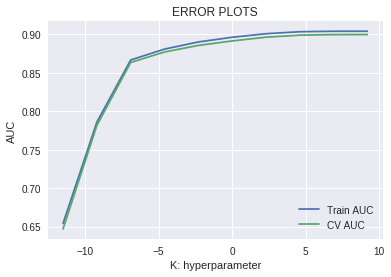

In [46]:
#C = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
#penalty=['l1','l2'] Already declared in L1
train_w2v_l2 = []
cv_w2v_l2= []
for t in C:
    neigh_w2v_l2 = LogisticRegression(penalty='l2',C=t)
    model_w2v_l2 = neigh_w2v_l2.fit(tfidf_train_vectors, y_train)
    y_train_predw2v_l2 =  model_w2v_l2.predict_proba(tfidf_train_vectors)[:,1]
    y_cv_predw2v_l2 =  model_w2v_l2.predict_proba(tfidf_cv_vectors)[:,1]
    train_w2v_l2.append(roc_auc_score(y_train,y_train_predw2v_l2))
    cv_w2v_l2.append(roc_auc_score(y_cv, y_cv_predw2v_l2))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_w2v_l2, label='Train AUC')
plt.plot(np.log(C), cv_w2v_l2, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [47]:
optimal_alpha_train = C[train_w2v_l2.index(max(train_w2v_l2))] 
print('\nThe optimal number of train value in C is %f.' % optimal_alpha_train)
print('-'*50)
optimal_alpha_cv = C[cv_w2v_l2.index(max(cv_w2v_l2))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_cv)


The optimal number of train value in C is 10000.000000.
--------------------------------------------------

The optimal number of cv value in C is 10000.000000.


In [48]:
# instantiate learning model alpha = optimal_alpha
optimal_w2v_l2 = LogisticRegression(penalty='l2',C = optimal_alpha_cv)
# fitting the model
optimal_w2v_l2.fit(tfidf_train_vectors, y_train)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
pred_tfw2v_l2=optimal_w2v_l2.predict(tfidf_test_vectors) #test
pred_tfw2v_train_l2=optimal_w2v_l2.predict(tfidf_train_vectors)
# evaluate accuracy on test data
#from sklearn.metrics import roc_auc_score
auc_tfw2v_l2 = roc_auc_score(y_test, pred_tfw2v_l2)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_cv, auc_tfw2v_l2))


The Auc socre for value= 10000.000000 is 0.710664%


[[ 2384  2869]
 [  902 26845]]
   


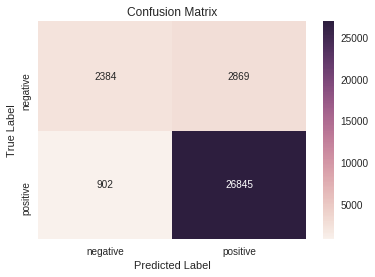

*************************************************************************************************
[[ 3333  3749]
 [ 1181 36627]]
   


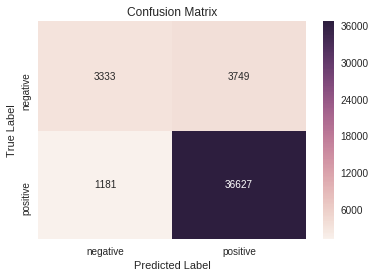

In [50]:
# Confusion Matrix
#from sklearn.metrics import confusion_matrix
cm_l2 = confusion_matrix(y_test, pred_tfw2v_l2)
print(cm_l2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
#import seaborn as sns
#class_label = ["negative", "positive"]
df_cm_w2vl2 = pd.DataFrame(cm_l2, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2vl2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_w2vl2 = confusion_matrix(y_train, pred_tfw2v_train_l2)
print(cm_w2vl2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
#import seaborn as sns
#class_label = ["negative", "positive"]
df_cm_w2vl2 = pd.DataFrame(cm_w2vl2, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2vl2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

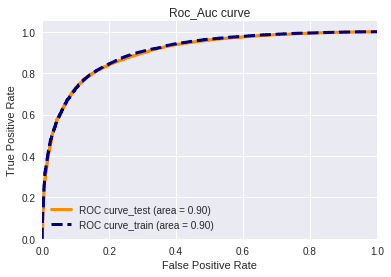

In [51]:
### Computing ROC curve and ROC area for predictions on l1 validation set
#from sklearn import metrics
y_test_w2v_predictl2 =  optimal_w2v_l2.predict_proba(tfidf_test_vectors)[:,1]
y_train_w2v_predictl2 =  optimal_w2v_l2.predict_proba(tfidf_train_vectors)[:,1]
train_fpr,train_tpr,_ =  metrics.roc_curve(y_train,y_train_w2v_predictl2) 
fpr_l2,tpr_l2, _ = metrics.roc_curve(y_test,y_test_w2v_predictl2)

roc_auc_test_l2 = auc(fpr_l2, tpr_l2) 
roc_auc_train_l2 = auc(train_fpr,train_tpr) 
### Plot
plt.figure()
#lw = 3
plt.plot(fpr_l2, tpr_l2, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc_test_l2)
plt.plot( train_fpr,train_tpr,color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc_train_l2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## Conclusion section :